# Anooba - An introduction to ANOVA

In this mini tutorial, we investigate the **ANOVA** statistics tool.

The context is the following:

We are experimenting with [DAPHNE](https://daphne-eu.eu/).
DAPHNE can automatically parallelize computation tasks, and has several configuration knobs in the parallelization.

We will focus only on two of them:

- the queue `layout`: DAPHNE can either have one `CENTRALIZED` queue hosting all the tasks, or one queue per socket (`PERGROUP`), or even one queue `PERCPU`.

- the scheduling `scheme`: the size of the tasks is crucial for performance and load imbalance. DAPHNE has several scheduling scheme (`STATIC`, `GSS`, etc) which have all a different way to split the work into tasks.

The question that we are asking ourselves is: **How do the queue layouts and the scheduling schemes impact the execution time of a DAPHNE application?**

We design the experimental plan, and for each combination (`layout`, `scheme`) we repeated 5 times the experiment.

It is now time to do the analysis of the data!

In [12]:
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.stats.anova as anova
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from lib_tuto import cld

The dataset containing all the data is "data.csv".
It actually contains more than necessary for this tutorial, so we will only keep the interesting data for this tutorial.

In [3]:
df = pd.read_csv("data.csv", sep=',')
# Limiting ourselves to a subset of the data
df = df[(df["script"] == "cc") & (df["slurm_partition"] == "xeon") & (df["victim_selection"] == "SEQ")]
# Getting rid of the columns that do not matter here
df = df.drop(["do_log", "matrix_name", "script", "slurm_partition", "victim_selection"], axis = 1)
df

,exec_time,scheme,layout
0,24.6318,STATIC,PERCPU
1,24.7490,STATIC,PERCPU
2,25.0220,STATIC,PERCPU
3,25.0603,STATIC,PERCPU
4,24.6684,STATIC,PERCPU
...,...,...,...
1495,25.8858,PSS,CENTRALIZED
1496,26.4819,PSS,CENTRALIZED
1497,26.0364,PSS,CENTRALIZED
1498,26.1356,PSS,CENTRALIZED


Let's first try to generate some plots!

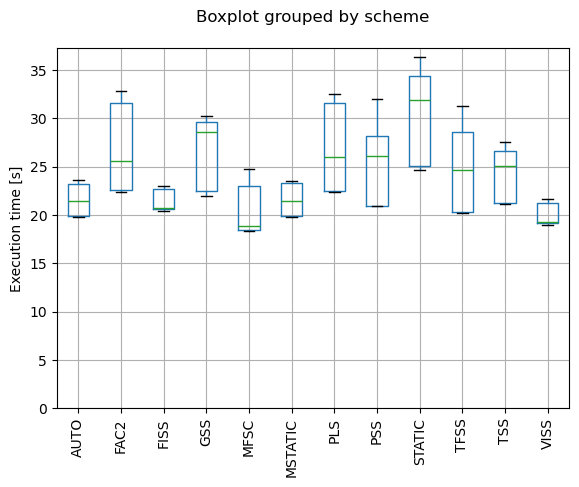

In [4]:
df.boxplot(column="exec_time", by="scheme", rot=90)
plt.xlabel("")
plt.ylabel("Execution time [s]")
plt.title("")
plt.ylim(bottom=0) 
plt.show()

Ok. Difficult to conclude anything. Some schemes seem to perform quite better than others, but there are also some large spread of data. 

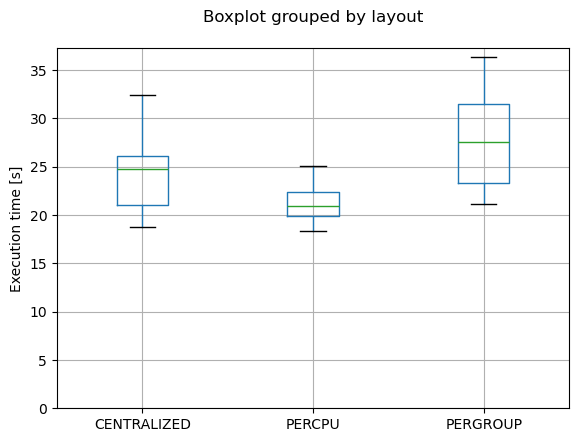

In [5]:
df.boxplot(column="exec_time", by="layout")
plt.xlabel("")
plt.ylabel("Execution time [s]")
plt.title("")
plt.ylim(bottom=0)
plt.show()

In the case of the queue `layout`s the visual conclusion is that `PERCPU` is better than `CENTRALIZED` which is better than `PERGROUP`. 

But the boxplots overlap, so we should use statistical tools to conclude.

Let's try to visualize the impact of the queue `layout` and the impact on the scheduling `scheme` on the execution time of the application.

In [6]:
df_summarized = df.groupby(["scheme", "layout"], as_index=False).mean().sort_values(by=["layout", "exec_time"])

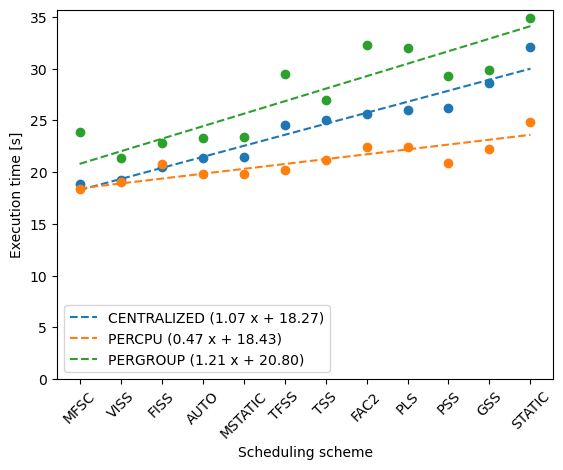

In [7]:
for layout in df_summarized["layout"].unique():
    df_tmp = df_summarized[df_summarized["layout"] == layout]
    x = df_tmp["scheme"]
    y = df_tmp["exec_time"]
    x_line = list(range(len(y.index)))
    m, b = np.polyfit(x_line, y.values, deg=1)
    y_line = list(map(lambda a: a * m + b, x_line))
    p0 = plt.plot(x, y, "o")
    plt.plot(x_line, y_line, linestyle="dashed", color=p0[0].get_color(), label=f"{layout} ({m:.2f} x + {b:.2f})")

plt.xlabel("Scheduling scheme")
plt.ylabel("Execution time [s]")
plt.title("")
plt.ylim(bottom=0)
plt.xticks(rotation=45)
plt.legend()
plt.show()

Let's stop for a minute and try to interpret this graph.

The x-axis represents the scheduling `scheme`s, and the lines represent the queue `layout`s.
The y-axis is the *mean* execution time of the scheduling `scheme` for the considered queue `layout`.

As we are working with factor values (scheduling scheme names) we ordered the `scheme`s by their mean execution time on the `CENTRALIZED` queue layout, and we keep this ordering for the others queue `layout`s.

The impact of the `scheme` can be seen on the distance between points of the **same line**.

The impact of the `layout` can be seen on the distance between points of the **same x value**.

In the plot above, we can see that the scheduling `scheme` has an impact on performance, as well as the queue `layout`.
We can interpret that `PERCPU` yields better results than `CENTRALIZED`, and that `CENTRALIZED` yields better results than `PERGROUP` (lower the better).
Concerning the scheduling `scheme`s, the ordering based on performance between schemes depends on the layout, but hopefully the trend lines still give the correct interpretation.

If the lines were parallel, then there will be no interaction between the impact of `scheme` and `layout`.

However, as we can see, the lines are not parallel! **There is thus some interaction** between the scheduling `scheme`s and the queue `layout`s.

We can see (by the slope of the lines) that the impact of the scheduling `scheme` is less important for `PERCPU` than for `CENTRALIZED` and `PERGROUP`.

We can also notice that the impact of the queue `layout` is less important for the best performing scheduling `scheme`s (left schemes: `MFSC`, `VISS`, `FISS`, `AUTO`, and `MSTATIC`).

Simply interpreting this plot is not enough, and we should rely on statistics! 

First we will fit an ordinary least squares (`ols`) on the data:

In [8]:
fitted_lm = ols("exec_time ~ layout * scheme", data = df).fit()

The expression in quote is in "R style" and is asking for a relation between `exec_time` and a combination of `layout` and `scheme`.

This means that the model what we are asking to fit has the following form:

$$
X_{ij} =  \mu + \alpha_i + \beta_j + \gamma_{ij} + \varepsilon_{ij}
$$

where:

- $X_{ij}$ is the execution time for the $i$th `layout` and the $j$th `scheme`
- $\mu$ is the default execution time (the global mean execution time)
- $\alpha_i$ is the impact of the $i$th `layout`
- $\beta_j$ is the impact of the $j$th `scheme`
- $\gamma_{ij}$ is the impact of the **interaction** between `layout` and `scheme`
- $\varepsilon_{ij}$ is the noise (supposed Gaussian)

We can look at the details of the fitting, and at all the coefficients with the `.summary()` method

In [9]:
# fitted_lm.summary()

We can now perform the **ANOVA test**.

ANOVA stands for "**AN**alyze **O**f **VA**riance".

It tests if *at least one* of the coefficients is non-zero.

Let's say we only look for now at the impact of the queue `layout` ($\alpha$) then:

$$
H_0: \forall i, \alpha_i = 0
$$
$$
H_1: \exists i^*, \alpha_{i^*} \neq 0
$$

Less formally: if all the $\alpha_i$ are null, then the queue `layout` has no impact on the execution time.

The ANOVA test will return the probability to **reject** the hypothesis $H_0$ and being wrong.

With the `statsmodels` package the function is `anova_lm`.

In [17]:
sm.stats.anova_lm(fitted_lm)

,df,sum_sq,mean_sq,F,PR(>F)
layout,2.0,1242.023411,621.011706,3059.891424,1.071168e-118
scheme,11.0,1782.866974,162.078816,798.605846,4.229099e-123
layout:scheme,22.0,343.105774,15.595717,76.844285,2.558030e-68
Residual,144.0,29.225117,0.202952,NaN,NaN


How to read this?

The first column gives the different factors that we are considering: `layout` ($\alpha$), `scheme` ($\beta$) and their interaction `layout:scheme` ($\gamma$).

What really interests us in this table is the last column (`PR(>F)`), which represent a p-value of rejection $H_0$ and being wrong.

As we can see, the p-values are very small, so we can confidently say that the queue `layout`, the scheduling `scheme`, and their interaction (`layout:scheme`) have an impact on the execution time.

Great! 

Now what?

Well, we know at least that the impact of the queue `layout`s, the scheduling `scheme`s and their interaction are *significant*.

ANOVA just told us that there is an influence of the factor. But it did not say anything about the influences themselves...

For this we need to use another statistical tool: the **Tukey HSD** (Honestly Significant Difference).

In [10]:
thsd_layout = pairwise_tukeyhsd(df["exec_time"], df["layout"])

In [11]:
thsd_layout.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
CENTRALIZED,PERCPU,-3.1143,0.0,-4.6201,-1.6085,True
CENTRALIZED,PERGROUP,3.319,0.0,1.8132,4.8248,True
PERCPU,PERGROUP,6.4333,0.0,4.9274,7.9391,True


TukeyHSD compares the pairs of mean for each `layout`.

The first line compares the mean execution time of the `CENTRALIZED` layout versus the mean execution time of the `PERCPU` layout.

The column `meandiff` represents the mean of the difference between the `group2` and the `group1` (in this order).

So for the first line, it looks at the difference between `PERCPU` - `CENTRALIZED`.
This difference is negative because the execution times with the `CENTRALIZED` layout are longer.

The `lower` and `upper` columns represent the bounds of the 95% confidence interval for the value of the `meandiff`.

**If the confidence interval contains the value 0, then we cannot distinguish between the two groups.**

We can plot a representation of these confidence intervals with the `.plot_simultaneous()` method:

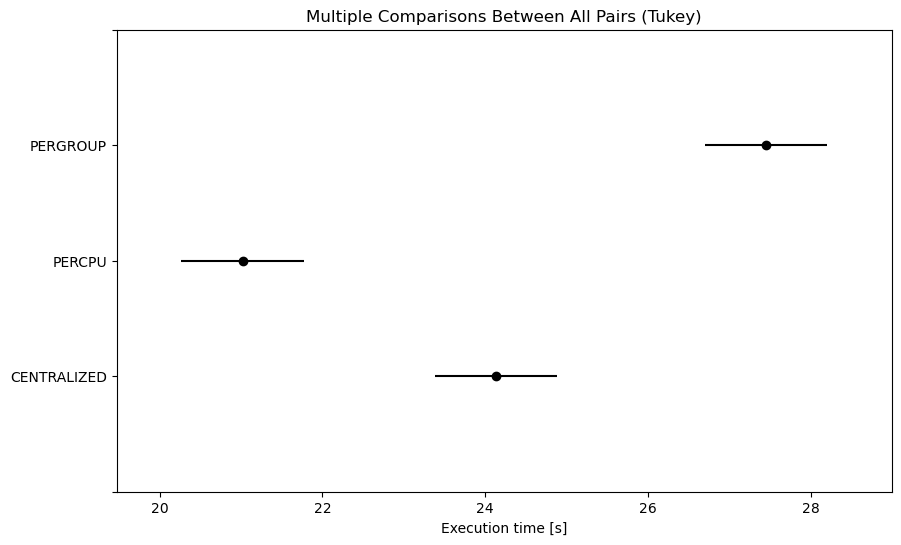

In [12]:
thsd_layout.plot_simultaneous()
plt.xlabel("Execution time [s]")
plt.show()

We can see that no confidence interval are overlapping, so we can conclude that `PERCPU` performs better than `CENTRALIZED`, which also perfoms better than `PERGROUP`.

However, it is not always that easy to interpret...

Let's take a look at the scheduling `scheme`s.

In [13]:
thsd_scheme = pairwise_tukeyhsd(df["exec_time"], df["scheme"])

We can also take a look at the detail of this TukeyHSD:

In [14]:
# thsd_scheme.summary()

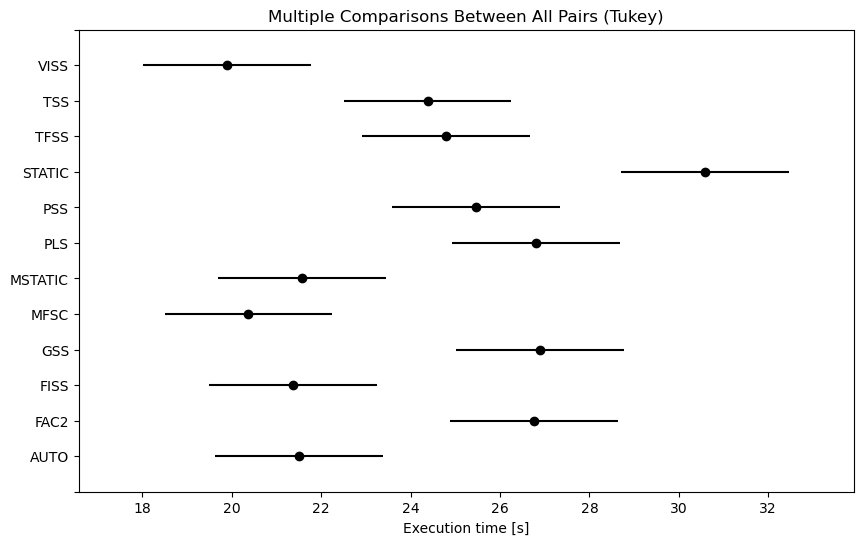

In [15]:
thsd_scheme.plot_simultaneous()
plt.xlabel("Execution time [s]")
plt.show()

How to conclude?

What we can roughly see is that `VISS`, `MSTATIC`, `MFSC`, `FISS` and `AUTO` seem to be indistinguishable.
Same for `TSS`, `TFSS`, `PSS`, `PLS`, `GSS`, and `FAC2`.
There are however some overlapping of confidence intervals: like `MSTATIC` and `TSS`.

Instead of trying to read the plot above, we can use the information of the TukeyHSD test to group the `scheme`s if they are indistinguishable.

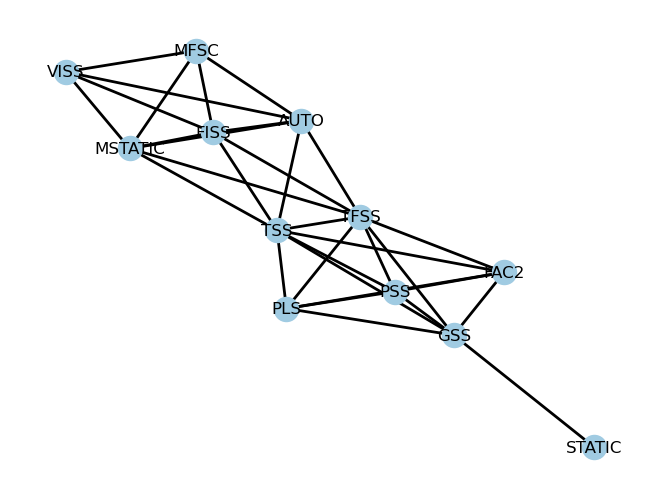

In [18]:
labels, G = cld(thsd_scheme)
nx.draw(G,with_labels=True, width=2, node_color="#A0CBE2")

Every edge of the plot above links two `scheme`s that are indistinguishable.

We can see 4 groups:

- `VISS`, `MFSC`, `MSTATIC`, `FISS`, `AUTO`

- `MSTATIC`, `FISS`, `AUTO`, `TFSS`, `TSS`

- `TFSS`, `TSS`, `PLS`, `PSS`, `FAC2`, `GSS`

- `GSS`, `STATIC`

We can assign a letter to each of these groups and create a label for each of the `scheme`. This is the idea of [Compact letter display (CLD)](https://en.wikipedia.org/wiki/Compact_letter_display) to help display results of ANOVA and TukeyHSD.

In [19]:
labels

{'AUTO': 'ad',
 'FAC2': 'bcd',
 'FISS': 'ad',
 'GSS': 'bcd',
 'MFSC': 'a',
 'MSTATIC': 'ad',
 'PLS': 'bcd',
 'PSS': 'bcd',
 'STATIC': 'c',
 'TFSS': 'abcd',
 'TSS': 'abcd',
 'VISS': 'a'}